In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, min, max, when, row_number,
    dayofweek, month, hour, avg, stddev, round
)
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("RecurrenciaClientesOlist_v2").getOrCreate()


In [2]:
customers = spark.read.parquet("./output/customers.parquet")
orders    = spark.read.parquet("./output/orders.parquet")
payments  = spark.read.parquet("./output/payments.parquet")
order_items = spark.read.parquet("./output/order_items.parquet")
products  = spark.read.parquet("./output/products.parquet")

print("customers:", customers.count())
print("orders   :", orders.count())


customers: 99441
orders   : 99441


In [3]:
# Unir orders con customers para tener customer_unique_id
orders_with_unique = orders.join(
    customers.select("customer_id", "customer_unique_id"),
    on="customer_id",
    how="inner"
)

# customer_unique_id count
ordenes_por_cliente = orders_with_unique.groupBy("customer_unique_id").agg(
    count("order_id").alias("num_ordenes"),
    min("order_purchase_timestamp").alias("primera_compra"),
    max("order_purchase_timestamp").alias("ultima_compra"),
)

ordenes_por_cliente = ordenes_por_cliente.withColumn(
    "tipo_cliente",
    when(col("num_ordenes") > 1, "Recurrente").otherwise("Unico")
)

print("Distribución global de clientes:")
ordenes_por_cliente.groupBy("tipo_cliente").count().show()


Distribución global de clientes:
+------------+-----+
|tipo_cliente|count|
+------------+-----+
|  Recurrente| 2997|
|       Unico|93099|
+------------+-----+



In [4]:
# customer_unique_id vs orders
window_first = Window.partitionBy("customer_unique_id").orderBy("order_purchase_timestamp")

orders_ranked = orders_with_unique.withColumn(
    "rn", row_number().over(window_first)
)

primeras_ordenes = orders_ranked.filter(col("rn") == 1).drop("rn")

print("Primeras órdenes:", primeras_ordenes.count())
primeras_ordenes.select("order_id", "customer_id", "customer_unique_id", "order_purchase_timestamp").show(5, truncate=False)


Primeras órdenes: 96096
+--------------------------------+--------------------------------+--------------------------------+------------------------+
|order_id                        |customer_id                     |customer_unique_id              |order_purchase_timestamp|
+--------------------------------+--------------------------------+--------------------------------+------------------------+
|6681163e3dab91c549952b2845b20281|2f29573c8cac5a7be11c5b649078f944|0006fdc98a402fceb4eb0ee528f6a8d4|2017-07-18 09:23:10     |
|85bf8863657bff31006811d45d1c8db9|40f0183f7439212e8ce53dc6103dfb2f|00090324bbad0e9342388303bb71ba0a|2018-03-24 14:44:41     |
|34801c59d6ec5c5e89bfefb6ebef314d|0e114b02a45c9876080f3a9a19f51c16|000c8bdb58a29e7115cfc257230fb21b|2017-12-12 22:53:35     |
|91d1bf2b7745903cb0d17162d1bbd750|064064dd94c43013786fc1e1a14d6374|00115fc7123b5310cf6d3a3aa932699e|2017-01-21 21:58:35     |
|7845d9a1a3d511b756a5c2c2352ba770|c267e32fea07ffc4d9d388d44c4106c7|001f3c4211216384d5fe59b041c

In [5]:
primeras_enriquecidas = primeras_ordenes \
    .join(payments, on="order_id", how="left") \
    .join(order_items, on="order_id", how="left") \
    .join(products, on="product_id", how="left")

# Features temporales
primeras_enriquecidas = primeras_enriquecidas \
    .withColumn("dia_semana", dayofweek("order_purchase_timestamp")) \
    .withColumn("mes", month("order_purchase_timestamp")) \
    .withColumn("hora", hour("order_purchase_timestamp"))

primeras_enriquecidas.select(
    "customer_unique_id", "order_id", "payment_type",
    "payment_installments", "payment_value",
    "product_category_name", "dia_semana", "mes", "hora"
).show(5, truncate=False)


+--------------------------------+--------------------------------+------------+--------------------+-------------+---------------------+----------+---+----+
|customer_unique_id              |order_id                        |payment_type|payment_installments|payment_value|product_category_name|dia_semana|mes|hora|
+--------------------------------+--------------------------------+------------+--------------------+-------------+---------------------+----------+---+----+
|0006fdc98a402fceb4eb0ee528f6a8d4|6681163e3dab91c549952b2845b20281|credit_card |2                   |29.0         |cama_mesa_banho      |3         |7  |9   |
|00090324bbad0e9342388303bb71ba0a|85bf8863657bff31006811d45d1c8db9|credit_card |3                   |63.66        |cama_mesa_banho      |7         |3  |14  |
|000c8bdb58a29e7115cfc257230fb21b|34801c59d6ec5c5e89bfefb6ebef314d|credit_card |2                   |29.0         |cama_mesa_banho      |3         |12 |22  |
|00115fc7123b5310cf6d3a3aa932699e|91d1bf2b7745903cb0

In [6]:
dataset_analisis = primeras_enriquecidas.join(
    ordenes_por_cliente.select("customer_unique_id", "num_ordenes", "tipo_cliente"),
    on="customer_unique_id",
    how="inner"
)

print("Muestra dataset_analisis:")
dataset_analisis.select(
    "customer_unique_id", "num_ordenes", "tipo_cliente",
    "payment_type", "payment_installments", "payment_value",
    "product_category_name", "dia_semana", "mes", "hora"
).show(10, truncate=False)

print("Distribución en dataset_analisis:")
dataset_analisis.groupBy("tipo_cliente").count().show()


Muestra dataset_analisis:
+--------------------------------+-----------+------------+------------+--------------------+-------------+----------------------+----------+---+----+
|customer_unique_id              |num_ordenes|tipo_cliente|payment_type|payment_installments|payment_value|product_category_name |dia_semana|mes|hora|
+--------------------------------+-----------+------------+------------+--------------------+-------------+----------------------+----------+---+----+
|0006fdc98a402fceb4eb0ee528f6a8d4|1          |Unico       |credit_card |2                   |29.0         |cama_mesa_banho       |3         |7  |9   |
|00090324bbad0e9342388303bb71ba0a|1          |Unico       |credit_card |3                   |63.66        |cama_mesa_banho       |7         |3  |14  |
|000c8bdb58a29e7115cfc257230fb21b|1          |Unico       |credit_card |2                   |29.0         |cama_mesa_banho       |3         |12 |22  |
|00115fc7123b5310cf6d3a3aa932699e|1          |Unico       |credit_ca

In [7]:
print("Método de pago por tipo de cliente (primera compra):")
dataset_analisis.groupBy("tipo_cliente", "payment_type") \
    .agg(count("*").alias("n")) \
    .orderBy("payment_type", "tipo_cliente") \
    .show(50, truncate=False)


Método de pago por tipo de cliente (primera compra):
+------------+------------+-----+
|tipo_cliente|payment_type|n    |
+------------+------------+-----+
|Unico       |NULL        |3    |
|Recurrente  |boleto      |752  |
|Unico       |boleto      |21522|
|Recurrente  |credit_card |2788 |
|Unico       |credit_card |81423|
|Recurrente  |debit_card  |40   |
|Unico       |debit_card  |1610 |
|Unico       |not_defined |2    |
|Recurrente  |voucher     |263  |
|Unico       |voucher     |5725 |
+------------+------------+-----+



In [8]:
print("Cuotas promedio por tipo de cliente:")
dataset_analisis.groupBy("tipo_cliente").agg(
    count("*").alias("n"),
    round(avg("payment_installments"), 2).alias("prom_cuotas"),
    round(stddev("payment_installments"), 2).alias("std_cuotas")
).show()


Cuotas promedio por tipo de cliente:
+------------+------+-----------+----------+
|tipo_cliente|     n|prom_cuotas|std_cuotas|
+------------+------+-----------+----------+
|  Recurrente|  3843|       3.33|      3.07|
|       Unico|110285|       2.91|      2.75|
+------------+------+-----------+----------+



In [9]:
print("Valor de primera compra por tipo de cliente:")
dataset_analisis.groupBy("tipo_cliente").agg(
    count("*").alias("n"),
    round(avg("payment_value"), 2).alias("prom_pago"),
    round(stddev("payment_value"), 2).alias("std_pago"),
    round(min("payment_value"), 2).alias("min_pago"),
    round(max("payment_value"), 2).alias("max_pago")
).show()


Valor de primera compra por tipo de cliente:
+------------+------+---------+--------+--------+--------+
|tipo_cliente|     n|prom_pago|std_pago|min_pago|max_pago|
+------------+------+---------+--------+--------+--------+
|  Recurrente|  3843|   172.09|  244.57|     0.0| 4950.34|
|       Unico|110285|   173.23|  271.35|     0.0|13664.08|
+------------+------+---------+--------+--------+--------+



In [10]:
print("Día de la semana de la primera compra (1=Dom, 7=Sáb segun tu config):")
dataset_analisis.groupBy("tipo_cliente", "dia_semana") \
    .agg(count("*").alias("n")) \
    .orderBy("dia_semana", "tipo_cliente") \
    .show(50, truncate=False)


Día de la semana de la primera compra (1=Dom, 7=Sáb segun tu config):
+------------+----------+-----+
|tipo_cliente|dia_semana|n    |
+------------+----------+-----+
|Recurrente  |1         |427  |
|Unico       |1         |13099|
|Recurrente  |2         |594  |
|Unico       |2         |17981|
|Recurrente  |3         |608  |
|Unico       |3         |17818|
|Recurrente  |4         |625  |
|Unico       |4         |17246|
|Recurrente  |5         |653  |
|Unico       |5         |16402|
|Recurrente  |6         |539  |
|Unico       |6         |15776|
|Recurrente  |7         |397  |
|Unico       |7         |11963|
+------------+----------+-----+



In [11]:
from pyspark.sql.functions import expr

# Filtrar categorías con al menos 100 clientes
cat_stats = dataset_analisis.filter(col("product_category_name").isNotNull()) \
    .groupBy("product_category_name", "tipo_cliente") \
    .agg(count("*").alias("n")) \
    .groupBy("product_category_name") \
    .pivot("tipo_cliente", ["Recurrente", "Unico"]) \
    .sum("n") \
    .na.fill(0)

cat_stats = cat_stats.withColumn("total", col("Recurrente") + col("Unico")) \
    .filter(col("total") >= 100) \
    .withColumn("tasa_recurrencia_pct",
        round(col("Recurrente") / col("total") * 100, 2)
    ) \
    .orderBy(col("tasa_recurrencia_pct").desc())

print("Top 20 categorías por tasa de recurrencia (min 100 clientes):")
cat_stats.select("product_category_name", "Recurrente", "Unico", "total", "tasa_recurrencia_pct") \
    .show(20, truncate=False)


Top 20 categorías por tasa de recurrencia (min 100 clientes):
+------------------------------+----------+-----+-----+--------------------+
|product_category_name         |Recurrente|Unico|total|tasa_recurrencia_pct|
+------------------------------+----------+-----+-----+--------------------+
|eletrodomesticos              |66        |644  |710  |9.3                 |
|moveis_quarto                 |9         |110  |119  |7.56                |
|fashion_bolsas_e_acessorios   |125       |1872 |1997 |6.26                |
|fashion_calcados              |16        |251  |267  |5.99                |
|moveis_decoracao              |442       |7877 |8319 |5.31                |
|fashion_roupa_masculina       |7         |131  |138  |5.07                |
|moveis_sala                   |25        |480  |505  |4.95                |
|cama_mesa_banho               |538       |10616|11154|4.82                |
|alimentos                     |24        |482  |506  |4.74                |
|construcao_fe

In [12]:
dataset_analisis.select(
    "customer_unique_id", "num_ordenes", "tipo_cliente",
    "payment_type", "payment_installments", "payment_value",
    "product_category_name", "dia_semana", "mes", "hora"
).write.mode("overwrite").parquet("./output/recurrencia_primeras_ordenes.parquet")

cat_stats.write.mode("overwrite").parquet("./output/recurrencia_categorias.parquet")

print("Exportados:")
print(" - ./output/recurrencia_primeras_ordenes.parquet")
print(" - ./output/recurrencia_categorias.parquet")


Exportados:
 - ./output/recurrencia_primeras_ordenes.parquet
 - ./output/recurrencia_categorias.parquet


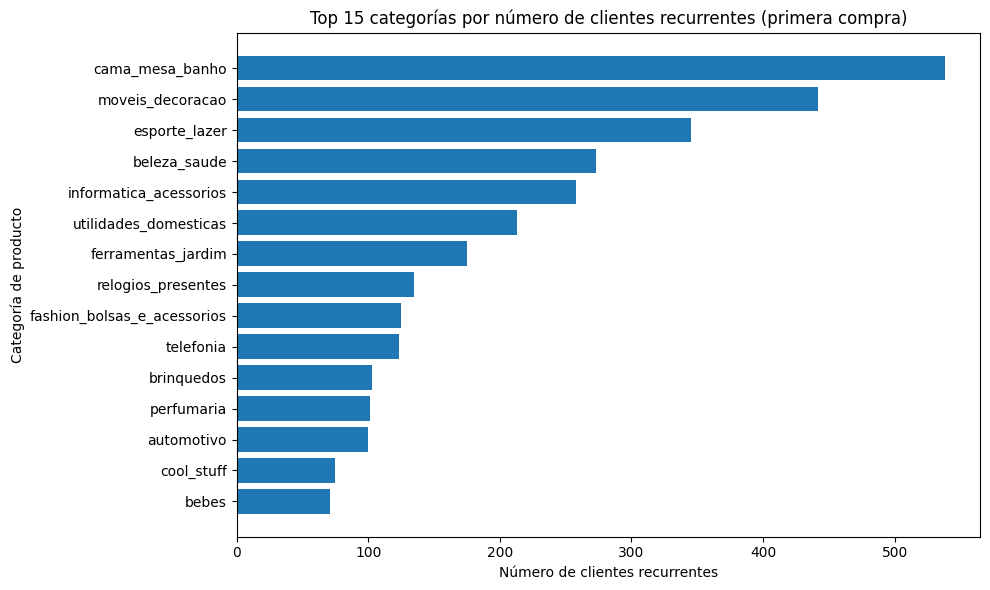

In [13]:
import matplotlib.pyplot as plt

# Top 15 categorías por número de clientes recurrentes
top_rec_vol = cat_stats.orderBy(col("Recurrente").desc()).limit(15)

pdf_top_rec_vol = top_rec_vol.select(
    "product_category_name", "Recurrente"
).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(pdf_top_rec_vol["product_category_name"], pdf_top_rec_vol["Recurrente"])
plt.gca().invert_yaxis()
plt.title("Top 15 categorías por número de clientes recurrentes (primera compra)")
plt.xlabel("Número de clientes recurrentes")
plt.ylabel("Categoría de producto")
plt.tight_layout()
plt.show()


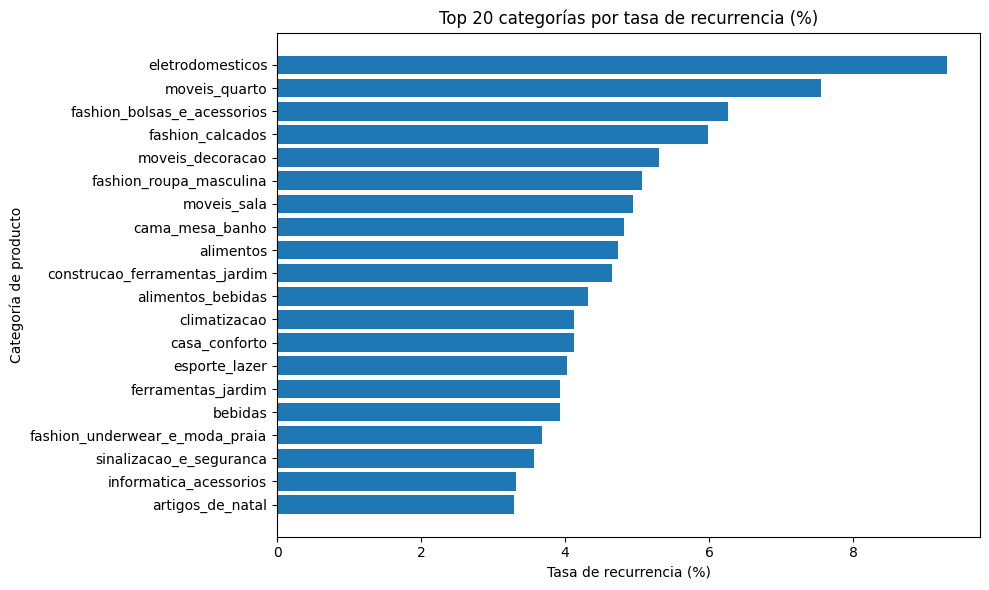

In [14]:
pdf_top_rec_rate = cat_stats.orderBy(col("tasa_recurrencia_pct").desc()).limit(20).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(pdf_top_rec_rate["product_category_name"], pdf_top_rec_rate["tasa_recurrencia_pct"])
plt.gca().invert_yaxis()
plt.title("Top 20 categorías por tasa de recurrencia (%)")
plt.xlabel("Tasa de recurrencia (%)")
plt.ylabel("Categoría de producto")
plt.tight_layout()
plt.show()


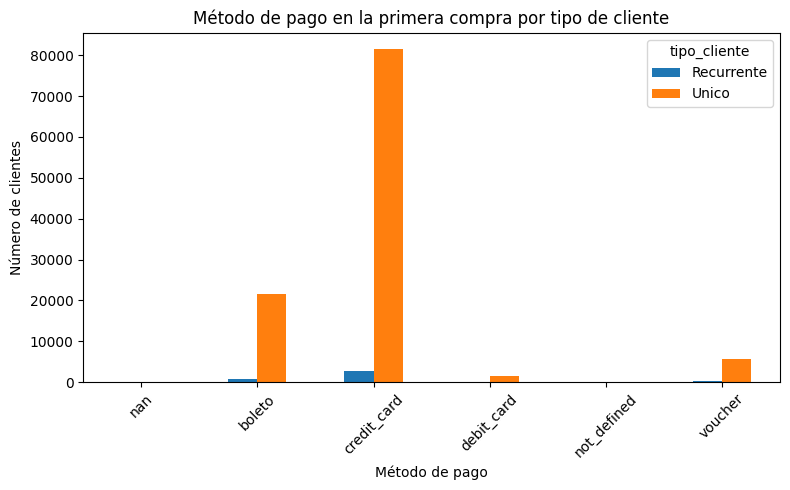

In [15]:
pago_tipo = dataset_analisis.groupBy("tipo_cliente", "payment_type") \
    .agg(count("*").alias("n"))

pdf_pago_tipo = pago_tipo.toPandas()
pivot_pago = pdf_pago_tipo.pivot(index="payment_type", columns="tipo_cliente", values="n").fillna(0)

pivot_pago.plot(kind="bar", figsize=(8, 5))
plt.title("Método de pago en la primera compra por tipo de cliente")
plt.xlabel("Método de pago")
plt.ylabel("Número de clientes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

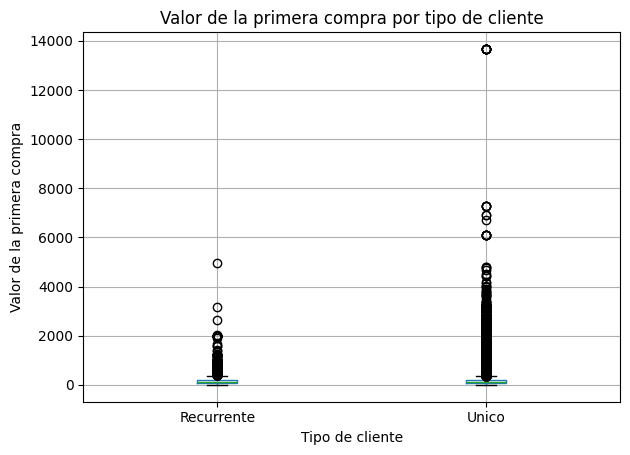

In [16]:
pdf_valor = dataset_analisis.select("tipo_cliente", "payment_value").toPandas()

plt.figure(figsize=(6, 5))
pdf_valor.boxplot(by="tipo_cliente", column="payment_value")
plt.title("Valor de la primera compra por tipo de cliente")
plt.suptitle("")
plt.xlabel("Tipo de cliente")
plt.ylabel("Valor de la primera compra")
plt.tight_layout()
plt.show()


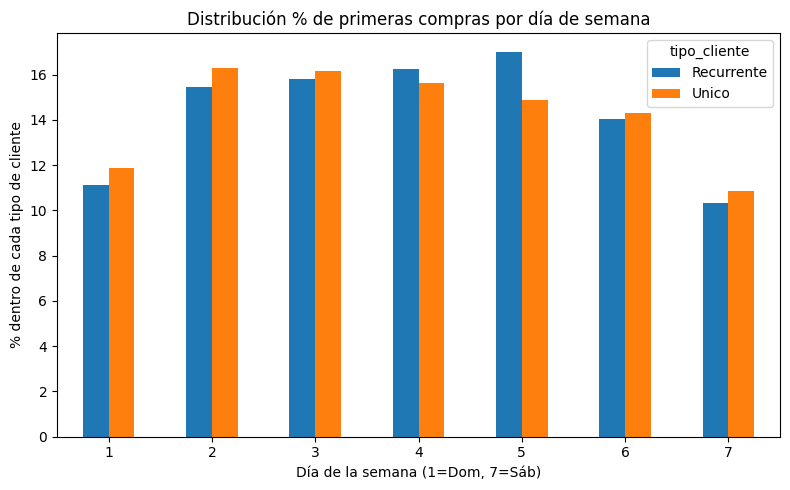

In [17]:
from pyspark.sql.functions import sum as spark_sum

# Conteos
dow_counts = dataset_analisis.groupBy("tipo_cliente", "dia_semana") \
    .agg(count("*").alias("n"))

# Total por tipo para normalizar
totales_tipo = dow_counts.groupBy("tipo_cliente") \
    .agg(spark_sum("n").alias("total"))

dow_norm = dow_counts.join(totales_tipo, on="tipo_cliente") \
    .withColumn("porc", col("n") / col("total") * 100)

pdf_dow = dow_norm.toPandas()
pivot_dow = pdf_dow.pivot(index="dia_semana", columns="tipo_cliente", values="porc").fillna(0)

pivot_dow.plot(kind="bar", figsize=(8, 5))
plt.title("Distribución % de primeras compras por día de semana")
plt.xlabel("Día de la semana (1=Dom, 7=Sáb)")
plt.ylabel("% dentro de cada tipo de cliente")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
### Diagnostico

In [25]:
from pyspark.sql.functions import when, col

# columnas relevantes de la primera compra
model_df = dataset_analisis.select(
    "customer_unique_id",
    "tipo_cliente",
    "payment_type",
    "payment_installments",
    "payment_value",
    "product_category_name",
    "dia_semana",
    "mes",
    "hora"
)

# 1 = recurrente, 0 = único
model_df = model_df.withColumn(
    "es_recurrente",
    when(col("tipo_cliente") == "Recurrente", 1).otherwise(0)
)

model_df.printSchema()
model_df.groupBy("es_recurrente").count().show()


root
 |-- customer_unique_id: string (nullable = true)
 |-- tipo_cliente: string (nullable = false)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: integer (nullable = true)
 |-- payment_value: double (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- dia_semana: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- hora: integer (nullable = true)
 |-- es_recurrente: integer (nullable = false)

+-------------+------+
|es_recurrente| count|
+-------------+------+
|            1|  3843|
|            0|110285|
+-------------+------+



In [26]:
import pandas as pd

pdf = model_df.toPandas()

# Eliminar nulos
pdf = pdf.dropna(subset=[
    "es_recurrente",
    "payment_type",
    "product_category_name",
    "payment_installments",
    "payment_value",
    "dia_semana",
    "mes",
    "hora"
])

y = pdf["es_recurrente"].astype(int)

# encoding
X = pd.get_dummies(
    pdf[[
        "payment_type",
        "product_category_name",
        "payment_installments",
        "payment_value",
        "dia_semana",
        "mes",
        "hora"
    ]],
    columns=["payment_type", "product_category_name"],
    drop_first=True
)

print("Shape X:", X.shape)
print("Porcentaje recurrentes (y=1):", y.mean())


Shape X: (111724, 80)
Porcentaje recurrentes (y=1): 0.03350220185457019


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Modelo base, sin balanceo
log_reg_base = LogisticRegression(
    max_iter=200,
    solver="lbfgs",
    n_jobs=-1
)

log_reg_base.fit(X_train, y_train)

y_pred_base = log_reg_base.predict(X_test)
y_proba_base = log_reg_base.predict_proba(X_test)[:, 1]

print("=== Modelo base (desbalanceado) ===")
print("AUC :", roc_auc_score(y_test, y_proba_base))
print(classification_report(y_test, y_pred_base, digits=3))


=== Modelo base (desbalanceado) ===
AUC : 0.6078428464755714
              precision    recall  f1-score   support

           0      0.966     1.000     0.983     32395
           1      0.000     0.000     0.000      1123

    accuracy                          0.966     33518
   macro avg      0.483     0.500     0.491     33518
weighted avg      0.934     0.966     0.950     33518



C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [28]:
from sklearn.metrics import precision_recall_curve

# Modelo con pesos balanceados
log_reg_bal = LogisticRegression(
    max_iter=200,
    solver="lbfgs",
    n_jobs=-1,
    class_weight="balanced"
)
log_reg_bal.fit(X_train, y_train)

y_proba_bal = log_reg_bal.predict_proba(X_test)[:, 1]

print("=== Modelo balanceado (class_weight='balanced') ===")
print("AUC :", roc_auc_score(y_test, y_proba_bal))

prec, rec, thr = precision_recall_curve(y_test, y_proba_bal)

print("\nMuestreo de puntos de la curva precisión–recall:")
for p, r, t in list(zip(prec, rec, thr))[::50]:
    print(f"umbral={t:.3f}  precision={p:.3f}  recall={r:.3f}")

best_threshold = 0.20

y_pred_bal = (y_proba_bal >= best_threshold).astype(int)

print(f"\n=== Métricas con umbral ajustado (t={best_threshold:.2f}) ===")
print(classification_report(y_test, y_pred_bal, digits=3))


=== Modelo balanceado (class_weight='balanced') ===
AUC : 0.6098119728413615

Muestreo de puntos de la curva precisión–recall:
umbral=0.074  precision=0.034  recall=1.000
umbral=0.242  precision=0.034  recall=0.999
umbral=0.251  precision=0.034  recall=0.999
umbral=0.257  precision=0.034  recall=0.998
umbral=0.263  precision=0.034  recall=0.997
umbral=0.268  precision=0.034  recall=0.997
umbral=0.273  precision=0.034  recall=0.997
umbral=0.276  precision=0.034  recall=0.996
umbral=0.279  precision=0.034  recall=0.995
umbral=0.284  precision=0.034  recall=0.992
umbral=0.287  precision=0.034  recall=0.992
umbral=0.290  precision=0.034  recall=0.989
umbral=0.293  precision=0.034  recall=0.988
umbral=0.296  precision=0.034  recall=0.986
umbral=0.299  precision=0.034  recall=0.985
umbral=0.302  precision=0.034  recall=0.985
umbral=0.305  precision=0.034  recall=0.984
umbral=0.307  precision=0.034  recall=0.981
umbral=0.308  precision=0.034  recall=0.981
umbral=0.310  precision=0.034  recall

In [29]:
import numpy as np

coef = pd.DataFrame({
    "feature": X.columns,
    "coef": log_reg_bal.coef_[0]
})
coef["abs_coef"] = coef["coef"].abs()

coef_sorted = coef.sort_values("abs_coef", ascending=False)

print("Top 30 variables por |coeficiente|:")
display(coef_sorted.head(30))


Top 30 variables por |coeficiente|:


,feature,coef,abs_coef
40,product_category_name_fashion_bolsas_e_acessorios,1.059989,1.059989
35,product_category_name_eletrodomesticos,0.965126,0.965126
33,product_category_name_cool_stuff,-0.743781,0.743781
20,product_category_name_cama_mesa_banho,0.499333,0.499333
61,product_category_name_moveis_decoracao,0.465215,0.465215
37,product_category_name_eletronicos,-0.449500,0.449500
73,product_category_name_relogios_presentes,-0.400855,0.400855
57,product_category_name_malas_acessorios,-0.350603,0.350603
66,product_category_name_papelaria,-0.314002,0.314002
47,product_category_name_ferramentas_jardim,0.301099,0.301099


In [30]:
# Solo columnas de categorías de producto
coef_categorias = coef[coef["feature"].str.startswith("product_category_name_")] \
    .sort_values("coef", ascending=False)

print("Top 15 categorías que MÁS aumentan prob. de recurrencia:")
display(coef_categorias.head(15))

print("Top 15 categorías que MÁS reducen prob. de recurrencia:")
display(coef_categorias.tail(15))


Top 15 categorías que MÁS aumentan prob. de recurrencia:


,feature,coef,abs_coef
40,product_category_name_fashion_bolsas_e_acessorios,1.059989,1.059989
35,product_category_name_eletrodomesticos,0.965126,0.965126
20,product_category_name_cama_mesa_banho,0.499333,0.499333
61,product_category_name_moveis_decoracao,0.465215,0.465215
47,product_category_name_ferramentas_jardim,0.301099,0.301099
39,product_category_name_esporte_lazer,0.300277,0.300277
63,product_category_name_moveis_quarto,0.225416,0.225416
8,product_category_name_alimentos,0.196433,0.196433
41,product_category_name_fashion_calcados,0.159449,0.159449
17,product_category_name_bebidas,0.139431,0.139431


Top 15 categorías que MÁS reducen prob. de recurrencia:


,feature,coef,abs_coef
69,product_category_name_perfumaria,-0.122154,0.122154
27,product_category_name_consoles_games,-0.129591,0.129591
68,product_category_name_pcs,-0.134364,0.134364
38,product_category_name_eletroportateis,-0.143040,0.143040
30,product_category_name_construcao_ferramentas_i...,-0.171850,0.171850
56,product_category_name_livros_tecnicos,-0.182918,0.182918
16,product_category_name_bebes,-0.184956,0.184956
52,product_category_name_instrumentos_musicais,-0.211390,0.211390
15,product_category_name_automotivo,-0.237652,0.237652
19,product_category_name_brinquedos,-0.259567,0.259567


In [31]:
coef_num = coef[coef["feature"].isin(["payment_installments", "payment_value"])]
coef_num


,feature,coef,abs_coef
0,payment_installments,0.071444,0.071444
1,payment_value,-0.000157,0.000157


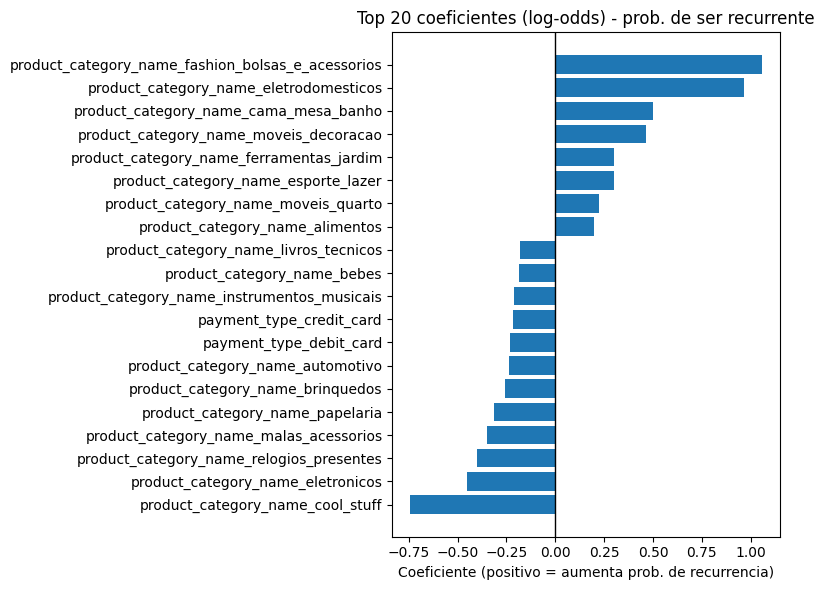

In [32]:
import matplotlib.pyplot as plt

topN = 20
top_features = coef_sorted.head(topN).sort_values("coef")

plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"], top_features["coef"])
plt.axvline(0, color="black", linewidth=1)
plt.title(f"Top {topN} coeficientes (log-odds) - prob. de ser recurrente")
plt.xlabel("Coeficiente (positivo = aumenta prob. de recurrencia)")
plt.tight_layout()
plt.show()
